In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

# read_data

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [3]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

In [4]:
# 발전량이 0인 시간대 (7시 이전, 17시 이후) 데이터는 제외
pv['time'] = [i.time() for i in pv['datetime']]
pv = pv[(pv['time']>=time(7, 0, 0)) & (pv['time']<time(17,0,0))]

In [5]:
pv.head()

,time,power,datetime,month,day,alt,azi,rad,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
7,07:00:00,30.2,2006-01-01 07:00:00-06:00,1,1,1.432672,117.660871,4.696817,15.1,15.1,100.0,0.3,NaN,150.0,0.0,NaN,1013.9,NaN,NaN
8,08:00:00,58.0,2006-01-01 08:00:00-06:00,1,1,12.143450,126.079567,636.876159,15.7,15.7,100.0,0.0,NaN,70.0,0.0,NaN,1013.6,NaN,NaN
9,09:00:00,139.3,2006-01-01 09:00:00-06:00,1,1,21.852863,136.311614,849.424805,16.8,16.2,96.0,0.0,NaN,180.0,9.4,NaN,1013.5,NaN,NaN
10,10:00:00,212.8,2006-01-01 10:00:00-06:00,1,1,29.715675,148.914476,932.421188,17.3,16.8,97.0,0.0,NaN,170.0,11.2,NaN,1013.3,NaN,NaN
11,11:00:00,303.3,2006-01-01 11:00:00-06:00,1,1,34.896395,164.064609,968.080363,16.8,16.2,96.0,0.0,NaN,160.0,9.4,NaN,1013.5,NaN,NaN


# decomposition

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
result = seasonal_decompose(pv['power'], freq=10)

<Figure size 432x288 with 0 Axes>

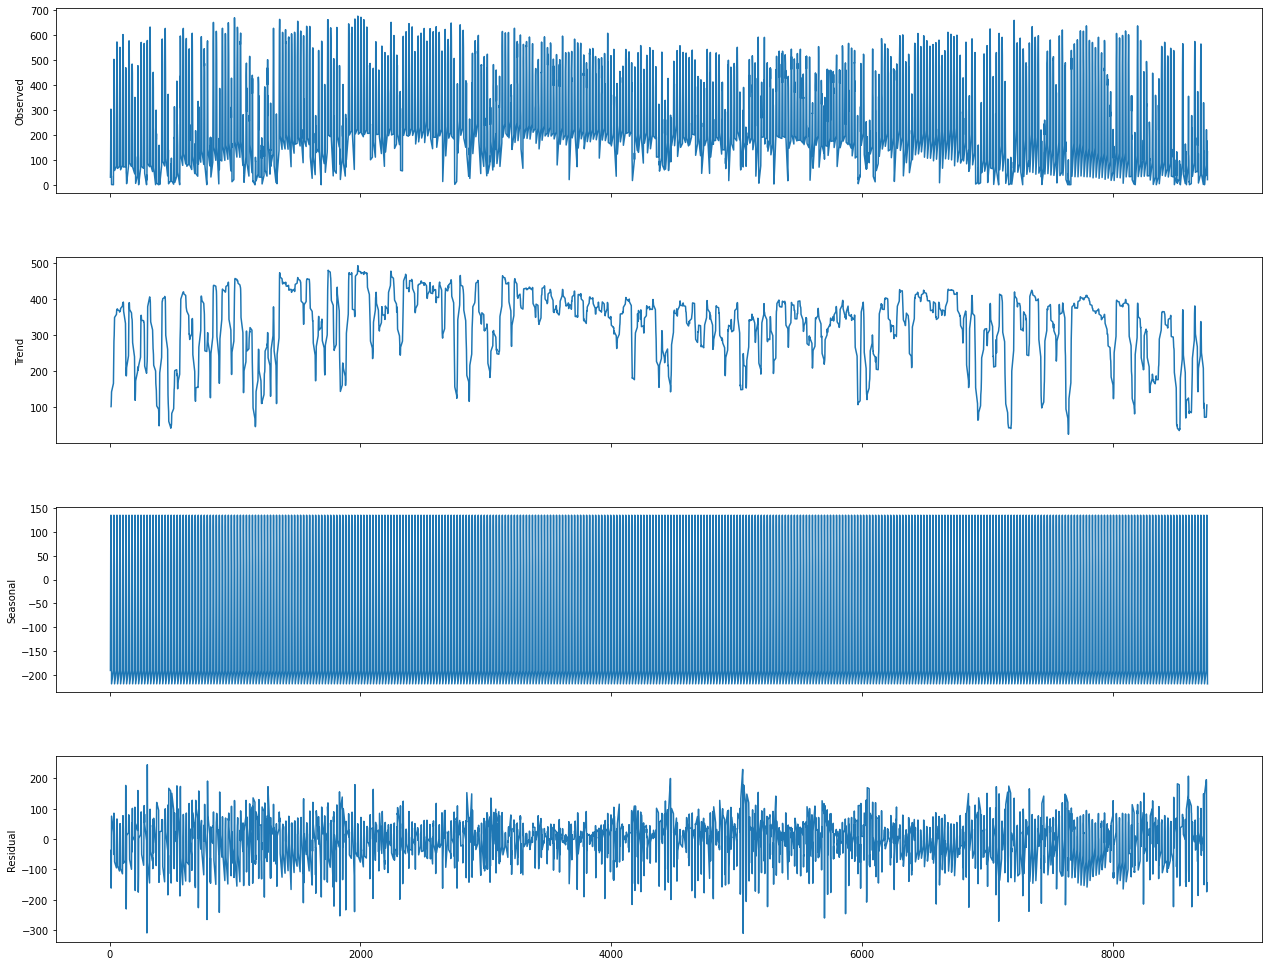

In [8]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

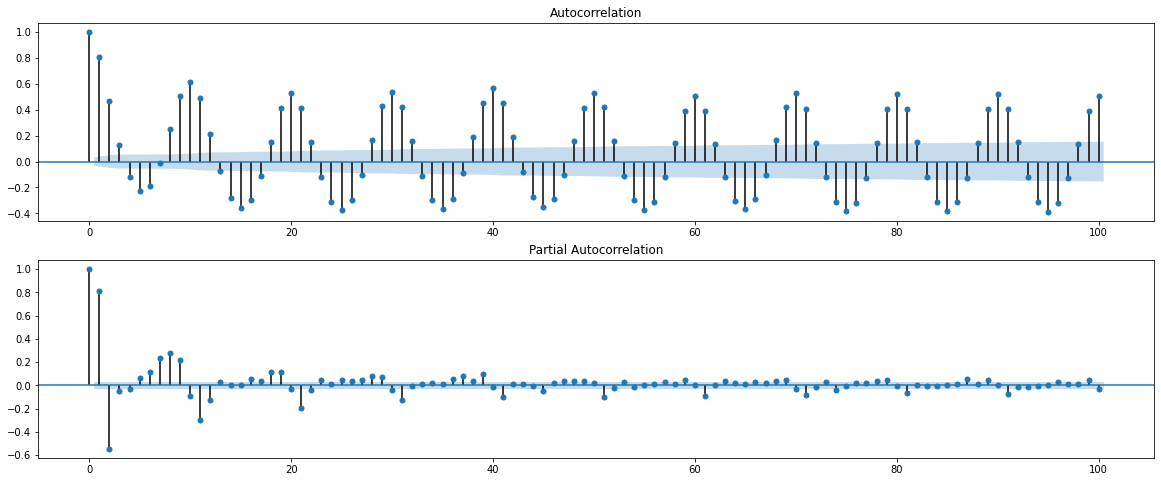

In [9]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pv['power'], lags=100, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pv['power'], lags=100, ax=ax2)

# 24 주기로 seasonality

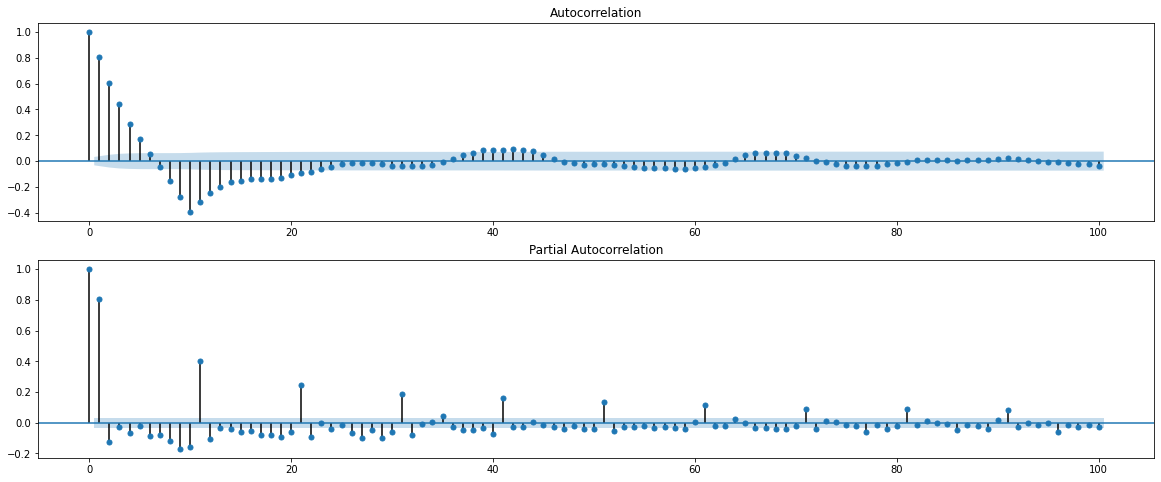

In [11]:
pv['power_diff'] = pv['power'].diff(10)
pv_temp = pv['power_diff'].dropna()

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pv_temp, lags=100, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pv_temp, lags=100, ax=ax2)

# SARIMA & SARIMAX

p : pacf에서 수렴하기 직전값

d : adf테스트 및 추세의 가시적 확인으로 추세여부 확인

q : acf에서 수렴하기 직전값

P : pacf에서 계절성이 주기가 몇 번 반복 됐는지 확인 

D : 계절성이 있는지 확인하고 계절성 차분의 필요성에 따라 1 or 0 

Q : acf기준 계절성 주기가 몇 번 반복 됐는지 확인

m : 계절성 주기 



In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
tz = timezone(timedelta(hours=-6))
start = datetime(2006,12,31,00,tzinfo=tz)
end = datetime(2006,12,31,23,00,tzinfo=tz)

# SARIMA

In [14]:
pv = pv.set_index('datetime')

In [15]:
pv_train = pv.loc[:datetime(2006,12,30,23,tzinfo=tz)]
pv_test = pv.loc[start:]

In [16]:
# 시각적으로 파악한 parameter -> 공부 필요
trend_order = (2,0,0)
seasonal_order = (1,0,0,10)

result = SARIMAX(endog=pv_train['power'], exog=None, order=trend_order, seasonal_order=seasonal_order).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [17]:
result.summary()
# -> 잔차 가정 만족 x, 처리 필요
# index 끊기면 sample 에 date type 으로 안 나옴

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              power   No. Observations:                 3640
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 10)   Log Likelihood              -21232.853
Date:                            Tue, 12 Apr 2022   AIC                          42473.706
Time:                                    06:13:26   BIC                          42498.505
Sample:                                         0   HQIC                         42482.539
                                           - 3640                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0427      0.014     72.914      0.000       1.015       1.071
ar.L2         -0.1687      0.014    -11.815      0.000      -0.197      -0.141
ar.S.L10       0.6209      0.013     47.804      0.000       0.595       0.646
sigma2      6813.5123    134.665     50.596      0.000    6549.574    7077.451
===================================================================================
Ljung-Box (Q):                      864.76   Jarque-Bera (JB):               255.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

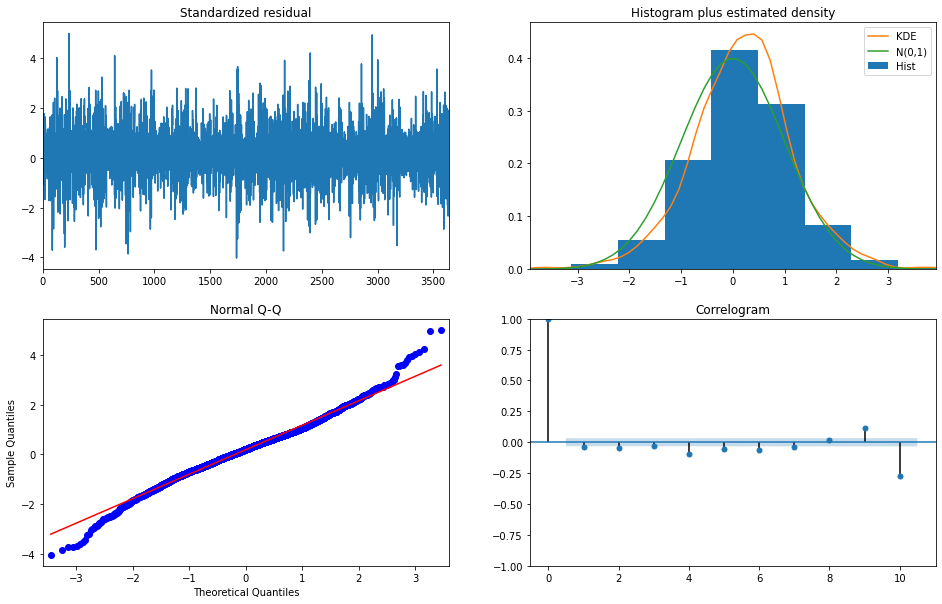

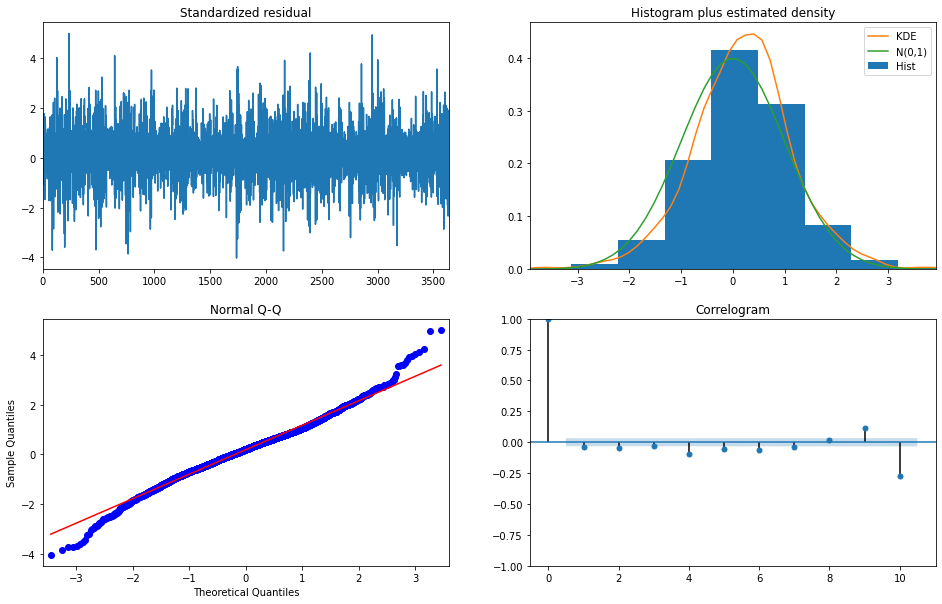

In [18]:
result.plot_diagnostics(figsize=(16,10))

In [20]:
pred = result.get_prediction(start=pv_train.shape[0], end=pv_train.shape[0]+9, exog=None, dynamic=False)
pv_test['pred_mean'] = pred.predicted_mean.values
pv_test[['lb', 'ub']] = pred.conf_int()[['lower power', 'upper power']]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


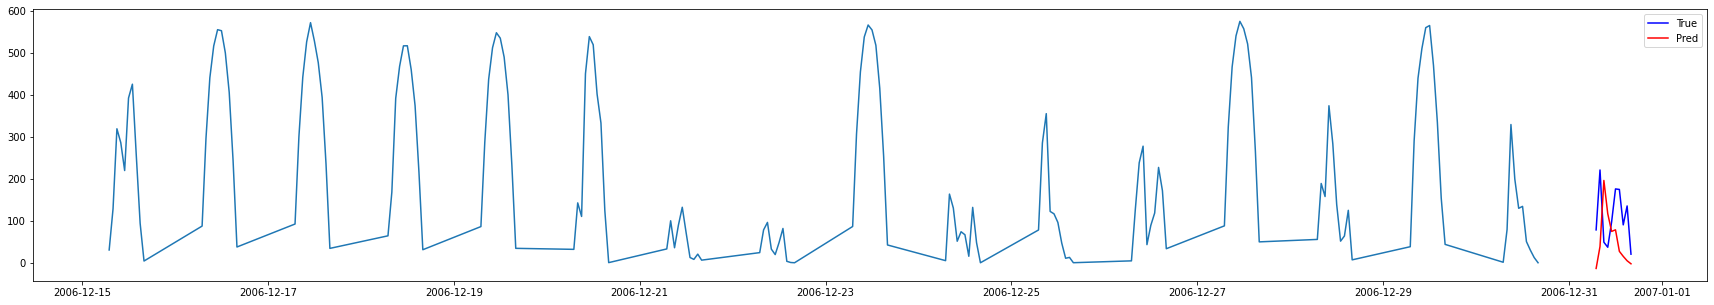

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 5)

# ax.fill_between(pv_test.index, pv_test['ub'], pv_test['lb'], facecolor='red', interpolate=True, alpha = 0.2)
ax.plot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):, 'power'])
ax.plot(pv_test.index, pv_test['power'], 'b', label='True')
ax.plot(pv_test.index, pv_test['pred_mean'], 'r', label='Pred')
plt.legend()

## SARIMAX

In [22]:
# 시각적으로 파악한 parameter -> 공부 필요
trend_order = (2,0,0)
seasonal_order = (1,0,0,24)

result = SARIMAX(endog=pv_train['power'], exog=pv_train[['dwpt', 'rhum', 'wspd', 'pres']], order=trend_order, seasonal_order=seasonal_order).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [23]:
result.summary()
# -> 잔차 가정 만족 x, 처리 필요

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              power   No. Observations:                 3640
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -21381.344
Date:                            Tue, 12 Apr 2022   AIC                          42778.688
Time:                                    06:17:01   BIC                          42828.286
Sample:                                         0   HQIC                         42796.353
                                           - 3640                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dwpt          -2.3040      0.578     -3.983      0.000      -3.438      -1.170
rhum           1.1264      0.181      6.230      0.000       0.772       1.481
wspd           0.1655      0.266      0.623      0.533      -0.355       0.686
pres           0.2634      0.014     18.477      0.000       0.235       0.291
ar.L1          1.2228      0.017     73.565      0.000       1.190       1.255
ar.L2         -0.5055      0.015    -33.400      0.000      -0.535      -0.476
ar.S.L24      -0.0701      0.018     -3.935      0.000      -0.105      -0.035
sigma2      7449.6633    184.941     40.281      0.000    7087.185    7812.142
===================================================================================
Ljung-Box (Q):                     2625.91   Jarque-Bera (JB):                32.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.16
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

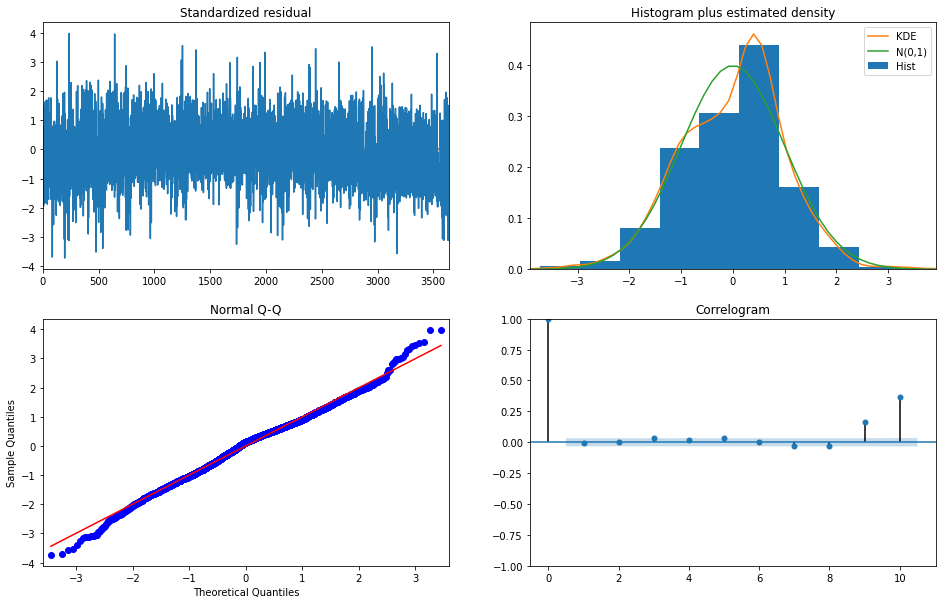

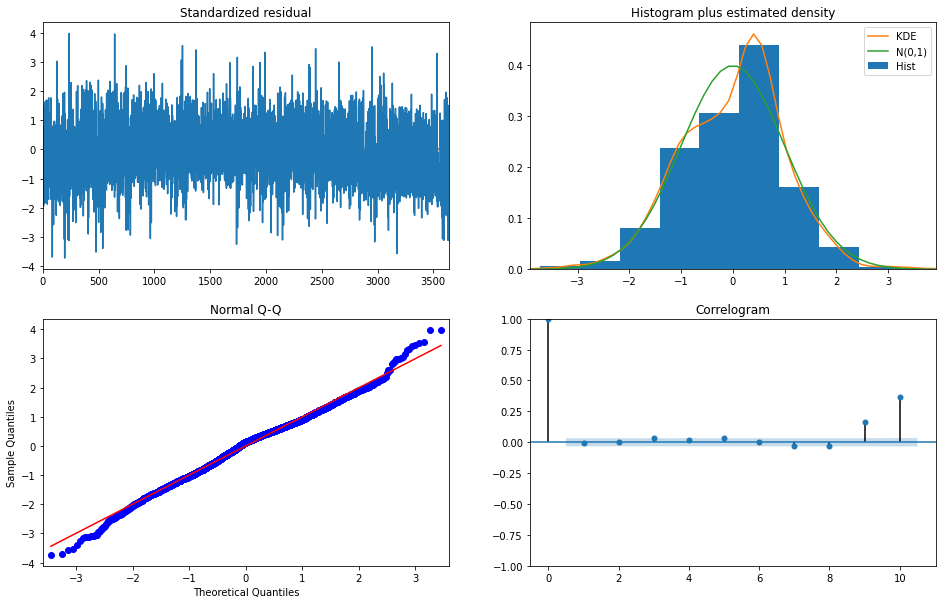

In [24]:
result.plot_diagnostics(figsize=(16,10))

In [26]:
pred = result.get_prediction(start=pv_train.shape[0], end=pv_train.shape[0]+9, exog=pv_test[['dwpt', 'rhum', 'wspd', 'pres']], dynamic=False)
pv_test['pred_mean'] = pred.predicted_mean.values
pv_test[['lb', 'ub']] = pred.conf_int()[['lower power', 'upper power']]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


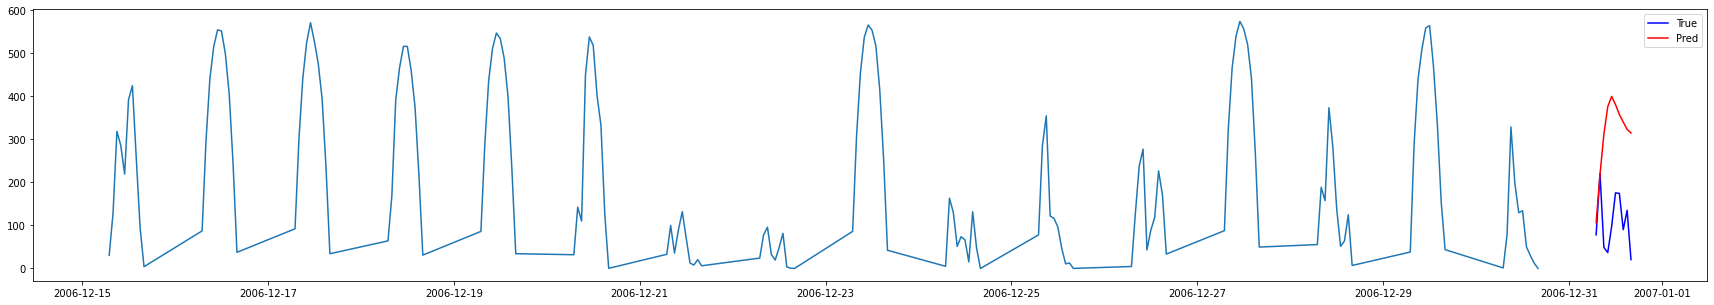

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 5)

# ax.fill_between(pv_test.index, pv_test['ub'], pv_test['lb'], facecolor='red', interpolate=True, alpha = 0.2)
ax.plot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):, 'power'])
ax.plot(pv_test.index, pv_test['power'], 'b', label='True')
ax.plot(pv_test.index, pv_test['pred_mean'], 'r', label='Pred')
plt.legend()